In [ ]:
# Standard libraries
import os
from random import sample, shuffle

# Data handling
import numpy as np
import pandas as pd
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score

# CV and SOTA models
import cv2
import segmentation_models_pytorch as smp


device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')

# Variable to control training mode
# if set to True, the model will be trained
# if set to False, the best model will be loaded and evaluated (Remember to have the best model saved and its metrics)
TRAIN = False

c:\Users\eliau\OneDrive\Desktop\ShipDetection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Mask Helper Function

In [2]:
def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decodes a Run-Length Encoded (RLE) string into a binary mask.

    Parameters
    ----------
    mask_rle : str or float
        The RLE-encoded string representing a binary mask.
        If the input is NaN or None, a mask of zeros is returned.
        Format of RLE: "start1 length1 start2 length2 ...", where indexing is 1-based and row-major.
    
    shape : tuple of int, optional
        The desired shape of the output mask in (height, width) format.
        Default is (768, 768).
    
    Returns
    -------
    np.ndarray
        A 2D binary mask of shape `shape`, where 1 indicates object presence and 0 background.
    """

    # Handle NaN or None input
    if pd.isnull(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    # Convert RLE string to list of integers
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[::2], s[1::2]

    # Convert 1-based indexing to 0-based for numpy and calculate start and end indices
    starts = np.array(starts) - 1  
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # Fill the mask with 1s at the specified start:end ranges
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    # Reshape the flat array into the desired shape
    return img.reshape((shape[1], shape[0])).T


def get_combined_mask(image_id, df, shape=(768, 768)):
    """
    Generates a combined binary mask for an image by decoding and summing
    all individual RLE masks associated with the image ID.
    Handles multiple ships by clipping overlapping regions to 1.

    Parameters
    ----------
    image_id : str
        The filename or unique identifier of the image (e.g., "00003e153.jpg").
    
    df : pandas.DataFrame
        A DataFrame containing at least two columns:
        - "ImageId": image filenames
        - "EncodedPixels": RLE-encoded mask strings.
    
    shape : tuple of int, optional
        The desired shape of the output mask in (height, width) format.
        Default is (768, 768).
    
    Returns
    -------
    np.ndarray
        A 2D binary mask of shape `shape`, where pixels are 1 if any mask for the image
        covers them, and 0 otherwise. Overlapping regions are clipped to 1.
    """


    rles = df[df["ImageId"] == image_id]["EncodedPixels"].dropna().values
    
    # If no RLEs are found, return an empty mask
    final_mask = np.zeros(shape, dtype=np.uint8)
    
    # Decode each RLE and accumulate the mask
    for rle in rles:
        final_mask += rle_decode(rle, shape=shape)
    
    # Clip the final mask to ensure binary values (0 or 1)
    final_mask = np.clip(final_mask, 0, 1)
    
    return final_mask

In [3]:
'''
The following code block is responsible for generating binary ship masks from the Run-Length Encoded (RLE) 
annotations provided in the CSV file (train_ship_segmentations_v2.csv).
These masks are saved as .png files inside the train_masks directory.
This will be useful for Dataset construction.
'''

# Configuration for mask folder generation
csv_path = r"C:airbus-ship-detection\train_ship_segmentations_v2.csv"
mask_output_dir = r"C:airbus-ship-detection\train_masks"

# Trarget size for the masks, should match the image size (768, 768)
target_size = (768, 768)
os.makedirs(mask_output_dir, exist_ok=True)

# if the mask directory is empty, generate masks
if os.path.exists(mask_output_dir) and len(os.listdir(mask_output_dir)) == 0:

    df = pd.read_csv(csv_path)
    df['HasShip'] = df['EncodedPixels'].notnull()
    grouped = df.groupby('ImageId')['EncodedPixels'].apply(list)

    # Generate masks for each image
    for image_id, rles in tqdm(grouped.items(), desc="Generating masks"):
        out_path = os.path.join(mask_output_dir, image_id.replace(".jpg", ".png"))

        if os.path.exists(out_path):
            continue  
        
        # Decode RLEs and create a mask, handle multiple ships correctly
        mask = np.zeros((768, 768), dtype=np.uint8)
        for rle in rles:
            if isinstance(rle, str):
                mask += rle_decode(rle)
        mask = np.clip(mask, 0, 1) * 255 

        mask_img = Image.fromarray(mask.astype(np.uint8))
        mask_img = mask_img.resize(target_size, resample=Image.NEAREST)
        mask_img.save(out_path)
else:
    print("Masks are already generated and saved in the specified directory.")

Masks are already generated and saved in the specified directory.


# Generic Helper Function

In [4]:
def show_image_with_mask(image_path, mask_df):
    """
    Displays an image with its corresponding mask overlay.
    - image_path: path to the image file
    - mask_df: DataFrame containing the masks
    """
    image = Image.open(image_path).convert("RGB")
    mask = get_combined_mask(os.path.basename(image_path), mask_df)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title("Combined Mask")
    plt.axis("off")
    plt.show()

# Mask Dataframe Construction

In [5]:
# Creating the mask DataFrame from the CSV file 
mask_df = pd.read_csv("./airbus-ship-detection/train_ship_segmentations_v2.csv")

#Count the number of times each image appears in the dataframe
mask_df['HasShip'] = mask_df['EncodedPixels'].notnull().astype(int)
ship_counts = mask_df.groupby('ImageId')['HasShip'].sum().reset_index()

#Setting ship count as a new column
ship_counts.rename(columns={'HasShip': 'ShipCount'}, inplace=True)
mask_df = mask_df.merge(ship_counts, on='ImageId', how='left')
mask_df

,ImageId,EncodedPixels,HasShip,ShipCount
0,00003e153.jpg,NaN,0,0
1,0001124c7.jpg,NaN,0,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1,5
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1,5
...,...,...,...,...
231718,fffedbb6b.jpg,NaN,0,0
231719,ffff2aa57.jpg,NaN,0,0
231720,ffff6e525.jpg,NaN,0,0
231721,ffffc50b4.jpg,NaN,0,0


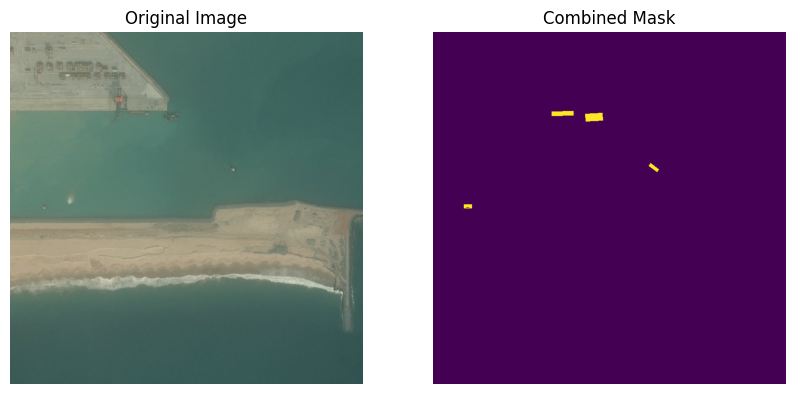

In [6]:
# Example usage of the show_image_with_mask function
show_image_with_mask("./airbus-ship-detection/train_v2/000194a2d.jpg", mask_df)

# Dataset Construction

In [7]:
# Creating lists of image and mask paths, useful for dataset construction

image_paths = sorted([
    os.path.join("./airbus-ship-detection/train_v2", f)
    for f in os.listdir("./airbus-ship-detection/train_v2") if f.endswith(".jpg")
])

mask_paths = sorted([
    os.path.join("./airbus-ship-detection/train_masks", f.replace(".jpg", ".png"))
    for f in os.listdir("./airbus-ship-detection/train_v2") if f.endswith(".jpg")
])


In [8]:
class ShipPatchDataset(Dataset):
    """
    A PyTorch Dataset for patch-based ship segmentation using the Airbus Ship Detection dataset.

    Each image (768×768) is divided into 9 non-overlapping patches of size 256×256.
    The dataset supports three modes: 'train', 'val', and 'test', each with different sampling and augmentation strategies.

    Key Features
    ------------
    - Patches are labeled as either containing ships (positive) or not (empty).
    - Allows control over Dataset sample size and Dataset ship-to-empty patch ratio.
    - Efficiently balances the dataset for training and evaluation.
    - Includes on-the-fly image/mask patch extraction and optional augmentation using Albumentations.

    Parameters
    ----------
    image_paths : list of str
        List of file paths to the original RGB images (.jpg).

    mask_paths : list of str
        List of file paths to the binary segmentation masks (.png), aligned with image_paths.

    patch_size : int, optional
        Size of each square patch to extract (default: 256). Assumes images are 768×768.

    mode : str, optional
        One of ['train', 'val', 'test']. Controls sampling strategy and augmentation pipeline.

    train_samples : int or None, optional
        If provided, limits the number of training patches sampled. Default behavior uses all ship patches
        plus an equal number of empty patches.

    val_samples : int or None, optional
        If provided, limits the number of validation patches sampled using the `ship_ratio`.

    test_samples : int or None, optional
        If provided, limits the number of test patches. Otherwise, all patches are used.

    ship_ratio : float, optional
        Ratio of ship-containing patches to total patches in validation and test modes. Default is 0.5 (balanced).
    """

    def __init__(self, image_paths, mask_paths, patch_size=256, mode='train', train_samples=None, val_samples=None, test_samples = None, ship_ratio=0.5):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.patch_size = patch_size
        self.mode = mode
        self.patch_indices = []
        self.augment = self.get_augmentation(mode)

        ship_patches = []
        empty_patches = []

        # Process masks to find ship patches and empty patches
        for img_idx, mask_path in enumerate(self.mask_paths):
            try:
                mask = np.array(Image.open(mask_path).convert("L"))
                for patch_idx in range(9):
                    y = (patch_idx // 3) * patch_size
                    x = (patch_idx % 3) * patch_size
                    patch = mask[y:y+patch_size, x:x+patch_size]

                    if patch.sum() > 0:
                        ship_patches.append((img_idx, patch_idx))
                    else:
                        empty_patches.append((img_idx, patch_idx))
            except Exception as e:
                print(f"Error processing mask {mask_path}: {e}")
                continue

        print(f"Total available: {len(ship_patches)} ship patches, {len(empty_patches)} empty patches")

        # Determine patch indices based on mode and sample sizes
        if mode == 'train':

            # For training: Use a fixed number of samples or all available patches
            if train_samples:
                num_ship = min(int(train_samples * 0.8), len(ship_patches))  # 80% ships
                num_empty = min(train_samples - num_ship, len(empty_patches))
                
                # Option 1: Use fixed number of ship and empty patches
                self.patch_indices = (sample(ship_patches, num_ship) + sample(empty_patches, num_empty))
                shuffle(self.patch_indices)
            else:

                # Option 2: Use all ship patches + equal number of empty patches
                num_empty = min(len(ship_patches), len(empty_patches))
                self.patch_indices = (ship_patches + sample(empty_patches, num_empty))
                shuffle(self.patch_indices)
                
        elif mode == 'val':

            # For validation: Use a fixed number of samples or balanced dataset
            if val_samples:
                
                # Option 1: Use fixed number of ship and empty patches
                num_ship = min(int(val_samples * ship_ratio), len(ship_patches))
                num_empty = min(val_samples - num_ship, len(empty_patches))
                
                self.patch_indices = (sample(ship_patches, num_ship) + sample(empty_patches, num_empty))
                shuffle(self.patch_indices)
            else:
                
                # Option 2: Use balanced validation if no specific sample size is given
                min_patches = min(len(ship_patches), len(empty_patches))
                self.patch_indices = (sample(ship_patches, min_patches) + sample(empty_patches, min_patches))
                shuffle(self.patch_indices)

        elif mode == 'test':

            # For testing: Use a fixed number of samples or all available patches
            if test_samples:

                # Option 1: Use fixed number of ship and empty patches
                num_samples = min(test_samples, len(ship_patches) + len(empty_patches))
                self.patch_indices = (sample(ship_patches, num_samples // 2) + sample(empty_patches, num_samples // 2))
                shuffle(self.patch_indices)
            else:
                
                # Option 2: Use all available patches
                self.patch_indices = ship_patches + empty_patches
                shuffle(self.patch_indices)

        # Count ship and empty patches for the current mode
        ship_count = sum(1 for img_idx, patch_idx in self.patch_indices if self._has_ship(img_idx, patch_idx))
        empty_count = len(self.patch_indices) - ship_count
        print(f"{mode.capitalize()} dataset: {ship_count} ship patches, {empty_count} empty patches\n")

    # Check if a patch has ship pixels
    def _has_ship(self, img_idx, patch_idx):
        try:
            mask = np.array(Image.open(self.mask_paths[img_idx]).convert("L"))
            y = (patch_idx // 3) * self.patch_size
            x = (patch_idx % 3) * self.patch_size
            patch = mask[y:y+self.patch_size, x:x+self.patch_size]
            return patch.sum() > 0
        except:
            return False

    # Define the augmentation pipeline based on the mode, if mode is 'train' it applies augmentations, otherwise it normalizes the image
    def get_augmentation(self, mode):
        if mode == 'train':
            return A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
                A.Rotate(limit=15, border_mode=0, p=0.3),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            return A.Compose([
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.patch_indices)

    def __getitem__(self, idx):
        img_idx, patch_idx = self.patch_indices[idx]
        
        try:
            # Load the image and mask
            image = np.array(Image.open(self.image_paths[img_idx]).convert("RGB"))
            mask = np.array(Image.open(self.mask_paths[img_idx]).convert("L"))

            # Extract patches
            y = (patch_idx // 3) * self.patch_size
            x = (patch_idx % 3) * self.patch_size

            image_patch = image[y:y+self.patch_size, x:x+self.patch_size, :]
            mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]

            # Ensure mask is binary (0 or 1)
            mask_patch = (mask_patch > 0).astype(np.uint8)

            # Apply augmentation
            augmented = self.augment(image=image_patch, mask=mask_patch)
            image_patch = augmented['image']
            mask_patch = augmented['mask']

            # Ensure mask is float and add channel dimension if needed
            if mask_patch.dim() == 2:
                mask_patch = mask_patch.unsqueeze(0)
            mask_patch = mask_patch.float()

            return image_patch, mask_patch
            
        except Exception as e:
            print(f"Error loading patch {idx}: {e}")
            return torch.zeros(3, self.patch_size, self.patch_size), torch.zeros(1, self.patch_size, self.patch_size)


# Usage examples:

# Option 1: Fixed sample size for computational efficiency
train_dataset = ShipPatchDataset(
    image_paths, mask_paths, 
    patch_size=256, 
    mode='train', 
    train_samples=20000  # 16k ship + 4k empty (80/20 split)
)

# Validation dataset (always balanced for fair evaluation)
val_dataset = ShipPatchDataset(
    image_paths, mask_paths, 
    patch_size=256, 
    mode='val', 
    val_samples=2000,  # 1k ship + 1k empty (balanced)
    ship_ratio=0.5
)

# create a test dataset of 500 images
test_dataset = ShipPatchDataset(
    image_paths, mask_paths, 
    patch_size=256,
    mode='test',  # Test mode, no augmentation
    test_samples=500, 
    ship_ratio=0.5  # Use same ratio as validation
)

Total available: 78883 ship patches, 1654121 empty patches
Train dataset: 16000 ship patches, 4000 empty patches

Total available: 78883 ship patches, 1654121 empty patches
Val dataset: 1000 ship patches, 1000 empty patches

Total available: 78883 ship patches, 1654121 empty patches
Test dataset: 250 ship patches, 250 empty patches



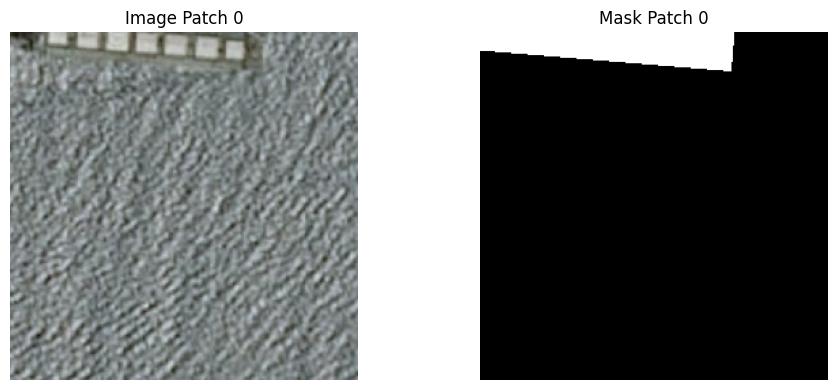

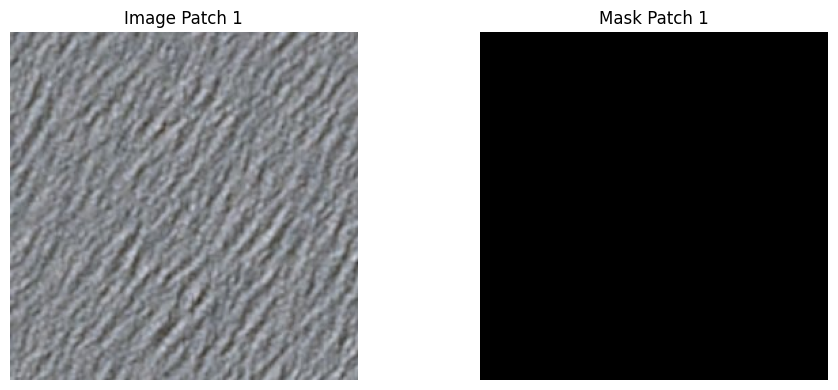

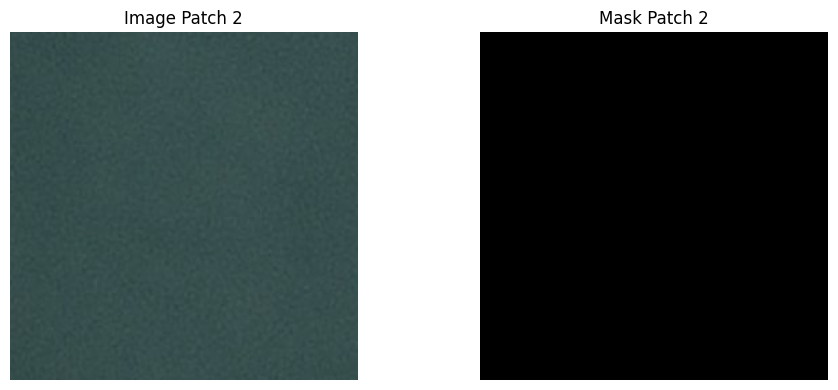

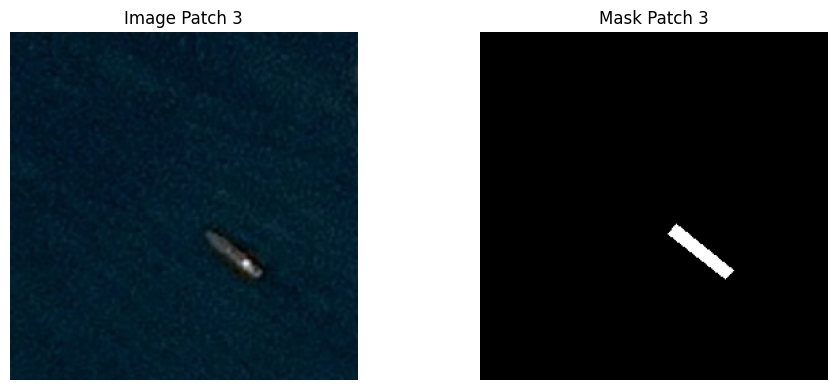

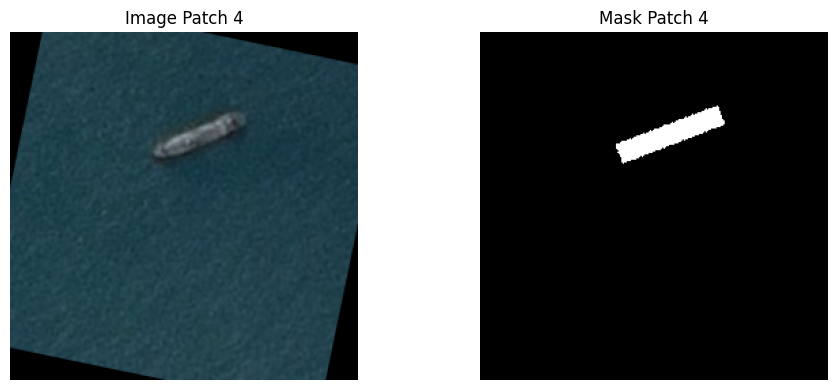

In [9]:
def visualize_samples(dataset, num_samples=5):
    """
    Visualizes a few image–mask pairs from a patch-based dataset.
    Useful for debugging and understanding the dataset.

    This function takes a dataset (e.g., an instance of ShipPatchDataset) and plots
    side-by-side visualizations of the RGB image patches and their corresponding binary masks.

    Denormalization is applied using ImageNet statistics to convert the image tensors
    back to a human-interpretable format before displaying.

    Parameters
    ----------
    dataset : torch.utils.data.Dataset
        A dataset object that returns (image_patch, mask_patch) tuples. The image must be normalized,
        and the mask must be binary (0 or 1).

    num_samples : int, optional
        Number of samples to visualize. Defaults to 5.

    Returns
    -------
    None
        The function displays plots using matplotlib but does not return anything.
    """
    
    # ImageNet normalization values
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for i in range(min(num_samples, len(dataset))):
        # Get the image and mask from the dataset
        img, mask = dataset[i]
        
        # Denormalize image for visualization
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Convert mask to numpy
        mask_np = mask.squeeze(0).numpy()
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np)
        plt.title(f"Image Patch {i}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title(f"Mask Patch {i}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize samples
visualize_samples(train_dataset, 5)

In [10]:
# Create DataLoaders for training, validation, and testing
# Note: Adjust batch_size as needed for your hardware capabilities (for my case 4 or 8 works well)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Network Definition

## Custom Net

The architecture implemented below takes inspiration from the **U-Net** design introduced by Ronneberger *et al.* in [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) \[@ronneberger2015unetconvolutionalnetworksbiomedical], in order to exploit effectiveness for dense prediction tasks like semantic segmentation, thanks to its encoder-decoder structure and skip connections that preserve spatial details.

To enhance the network’s performance while keeping the parameter count efficient, I employ **Squeeze-and-Excitation (SE) blocks**. Explained by Hu *et al.* in [Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507) \[@hu2019squeezeandexcitationnetworks], these blocks enable the network to adaptively recalibrate channel-wise feature responses, improving the model’s focus on informative features.

In addition, I employ **Residual connections** inside convolutional blocks when the input and output channel dimensions match, improving gradient flow and training stability.


In [11]:
import torch
import torch.nn as nn

# Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.pool(x)
        w = self.fc(w)
        return x * w

# Convolutional Block with Depthwise Separable Convolutions and SE Block
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, use_se=True, residual=True, dropout=0.0):
        super().__init__()
        self.residual = residual and in_ch == out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, padding=1, groups=in_ch),  # depthwise
            nn.Conv2d(in_ch, out_ch, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1, groups=out_ch),
            nn.Conv2d(out_ch, out_ch, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(inplace=True),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        )
        self.se = SEBlock(out_ch) if use_se else nn.Identity()

    def forward(self, x):
        out = self.conv(x)
        out = self.se(out)
        if self.residual:
            return out + x
        return out

class CustomNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(3, 64, dropout=0.1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128, dropout=0.1)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256, dropout=0.2)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(256, 512, dropout=0.3)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(512, 1024, dropout=0.4)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ConvBlock(1024, 512, dropout=0.3)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256, dropout=0.2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128, dropout=0.1)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64, dropout=0.1)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)       # 64
        x2 = self.enc2(self.pool1(x1))   # 128
        x3 = self.enc3(self.pool2(x2))   # 256
        x4 = self.enc4(self.pool3(x3))   # 512
        x5 = self.bottleneck(self.pool4(x4))  # 1024

        x = self.up4(x5)
        x = self.dec4(torch.cat([x, x4], dim=1))
        x = self.up3(x)
        x = self.dec3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        return self.final(x)  # logits
    
# Network Definition
model = CustomNet().to(device)

### Custom Loss Function Definition

In [ ]:
bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1):
    """
    Computes the Dice loss between predicted and target masks.

    Parameters
    ----------
    pred : torch.Tensor
        Predicted mask logits (shape: [batch_size, 1, height, width]).
    target : torch.Tensor
        Target mask (shape: [batch_size, 1, height, width]).
    smooth : float, optional
        Smoothing factor to avoid division by zero. Default is 1.
    
    Returns
    -------
    float
        The Dice loss value.
    """

    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice

def combined_loss(pred, target):
    """
    Computes a combined loss using Binary Cross-Entropy (BCE) and Dice loss.

    Parameters
    ----------
    pred : torch.Tensor
        Predicted mask logits (shape: [batch_size, 1, height, width]).
    target : torch.Tensor
        Target mask (shape: [batch_size, 1, height, width]).

    Returns
    -------
    float
        The combined loss value, which is a weighted sum of BCE and Dice loss.
    """
    bce_loss = bce(pred, target)
    dice_loss_val = dice_loss(pred, target)
    
    # You can adjust these weights based on your needs
    return 0.5 * bce_loss + 0.5 * dice_loss_val

## Helper Function for Networ and Training routine

In [28]:
def dice_coefficient(pred, target, smooth=1):
    """
    Calculate dice coefficient for evaluation
    """
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

In [14]:
def mask_to_box_mask(pred):
    """
    Converts a batch of binary segmentation masks into masks with filled bounding boxes.
    Input: pred (B, 1, H, W), binary mask
    Output: box_mask (B, 1, H, W), binary mask with bounding boxes
    """
    # Handle single prediction case
    if pred.dim() == 3:
        pred = pred.unsqueeze(0)
    
    pred_np = pred.squeeze(1).cpu().numpy()
    box_masks = []

    for mask in pred_np:
        mask = (mask * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        box_mask = np.zeros_like(mask)

        for contour in contours:
            if cv2.contourArea(contour) < 100:
                continue
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(box_mask, (x, y), (x + w, y + h), 255, thickness=-1)

        box_masks.append(box_mask)

    box_masks = torch.tensor(np.array(box_masks), dtype=torch.float32).unsqueeze(1).to(pred.device) / 255.0
    return box_masks

## Training and Validation Routine

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',          # because we want to maximize validation Dice
    factor=0.5,          # reduce LR by half
    patience=3,          # wait 3 epochs before reducing
)

num_epochs = 20

In [16]:
# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_dices = []
val_dices = []

In [17]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, total_dice = 0, 0

    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Use the combined loss
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            pred = torch.sigmoid(outputs) > 0.5
            pred = pred.float()
            
            # Convert predictions to bounding boxes and calculate dice with GT boxes
            box_pred = mask_to_box_mask(pred)
            dice = dice_coefficient(box_pred, masks)

        total_loss += loss.item()
        total_dice += dice.item()

    return total_loss / len(loader), total_dice / len(loader)

def validate(model, loader, device):
    model.eval()
    total_loss, total_dice = 0, 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = combined_loss(outputs, masks)
            pred = torch.sigmoid(outputs) > 0.5
            pred = pred.float()
            
            # Convert predictions to bounding boxes and calculate dice with GT boxes
            box_pred = mask_to_box_mask(pred)
            dice = dice_coefficient(box_pred, masks)

            total_loss += loss.item()
            total_dice += dice.item()

    return total_loss / len(loader), total_dice / len(loader)

if TRAIN == True:
    print("Starting training...")
    # Training loop
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        
        train_loss, train_dice = train_one_epoch(model, train_dataloader, optimizer, device)
        val_loss, val_dice = validate(model, val_dataloader, device)
        
        # Store metrics for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)

        # Adjust learning rate based on validation Dice
        scheduler.step(val_dice)
        
        # Fixed visualization
        plt.figure(figsize=(12, 4))
        img, mask = val_dataset[0]
        
        # Prepare image for model input
        img_input = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred_logits = model(img_input)
            pred_prob = torch.sigmoid(pred_logits)
            pred_binary = (pred_prob > 0.5).float()
            
            # Convert to bounding box mask
            box_pred = mask_to_box_mask(pred_binary)
        
        # Convert for visualization - denormalize the image
        img_vis = img.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_vis = img_vis * std + mean
        img_vis = np.clip(img_vis, 0, 1)
        
        mask_vis = mask.squeeze(0).cpu().numpy()
        box_pred_vis = box_pred.squeeze(0).squeeze(0).cpu().numpy()
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_vis)
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask_vis, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(box_pred_vis, cmap='gray')
        plt.title("Predicted Box Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

        print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}")
    
    print("Training complete. Saving the best model...")
    torch.save(model.state_dict(), "best_model_net_improve.pth")

    # save the metrics to a CSV file
    import pandas as pd
    metrics_df = pd.DataFrame({
        'Epoch': range(1, len(train_losses) + 1),
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Train Dice': train_dices,
        'Val Dice': val_dices
    })

    metrics_df.to_csv("training_metrics_improve.csv", index=False)

In [18]:
if TRAIN == False:
    print("Loading the best model for evaluation...")
    model.load_state_dict(torch.load("best_model_net_improve.pth"))

Loading the best model for evaluation...


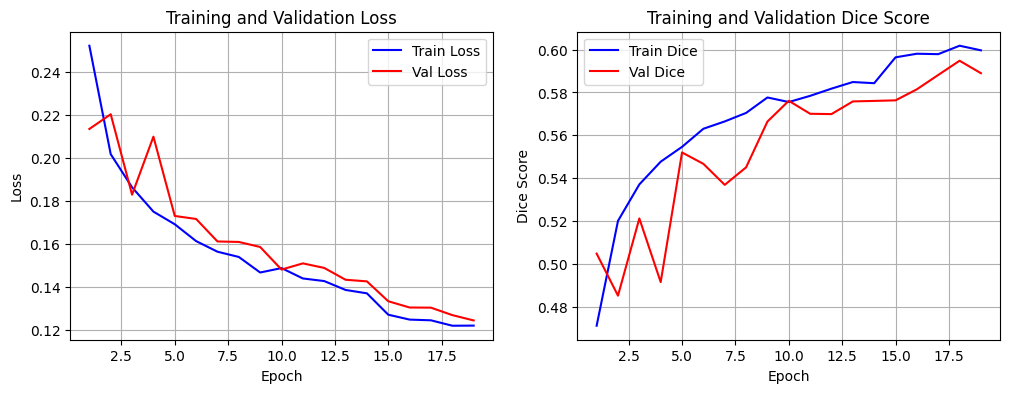

In [19]:
# Recreating the lists for working withg both trained model and loaded model
train_losses = pd.read_csv("training_metrics_improve.csv")['Train Loss'].tolist()
val_losses = pd.read_csv("training_metrics_improve.csv")['Val Loss'].tolist()
train_dices = pd.read_csv("training_metrics_improve.csv")['Train Dice'].tolist()
val_dices = pd.read_csv("training_metrics_improve.csv")['Val Dice'].tolist()

# learning curve traning and validation loss and dice score
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_dices) + 1), train_dices, 'b-', label='Train Dice')
plt.plot(range(1, len(val_dices) + 1), val_dices, 'r-', label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.grid(True)

plt.show()

## External Test Evaluation

To comprehensively evaluate the model's performance on the external test set, two different set of metrics were computed.


---

#### 1. Global Metrics (Overall Image-Level Performance)

These include: Iou, Dice Coefficient, Pixel Accuracy, Precision and Recall

These metrics are calculated by comparing all predicted and ground truth pixels across the entire test set, providing a global evaulation of segmentation quality. They are useful for comparing overall model performance.

In [ ]:
def evaluate_segmentation_model(model, dataloader, device='cuda'):
    """
    Evaluates a segmentation model on a given DataLoader and computes overall image metrics.

    Parameters
    ----------
    model : torch.nn.Module
        The segmentation model to evaluate.
    dataloader : torch.utils.data.DataLoader
        DataLoader containing the dataset to evaluate on.
    device : str, optional
        Device to run the evaluation on ('cuda' or 'cpu'). Default is 'cuda'.

    Returns
    -------
    dict
        A dictionary containing evaluation metrics: IoU, Dice coefficient, pixel accuracy, precision, and recall.
    """

    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5 # modify the threshold as needed
            preds = preds.long().cpu().numpy().reshape(-1)
            masks = masks.long().cpu().numpy().reshape(-1)

            all_preds.extend(preds)
            all_targets.extend(masks)

    # Compute metrics
    iou = jaccard_score(all_targets, all_preds, zero_division=0)
    dice = f1_score(all_targets, all_preds, zero_division=0)
    pixel_acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)

    print("External Test Metrics:")
    print(f"IoU (Jaccard):     {iou:.4f}")
    print(f"Dice Coefficient:  {dice:.4f}")
    print(f"Pixel Accuracy:    {pixel_acc:.4f}")
    print(f"Precision:         {precision:.4f}")
    print(f"Recall:            {recall:.4f}")

    return {
        'iou': iou,
        'dice': dice,
        'pixel_acc': pixel_acc,
        'precision': precision,
        'recall': recall
    }

# Evaluate the model on the test dataset
test_metrics = evaluate_segmentation_model(model, test_dataloader, device=device)

# Save the test metrics to a CSV file
test_metrics_df = pd.DataFrame([test_metrics])
test_metrics_df.to_csv("test_metrics.csv", index=False)
print("Test metrics saved to 'test_metrics.csv'.")



External Test Metrics:
IoU (Jaccard):     0.7198
Dice Coefficient:  0.8371
Pixel Accuracy:    0.9958
Precision:         0.8350
Recall:            0.8391
Test metrics saved to 'test_metrics.csv'.


---
#### 2. Patch-Wise Metrics (Class-Specific and Fair Evaluation)

To better capture the model's behavior across different types of samples in the test set, patchwise segmentation metrics were computed.

- **Mean Patch Dice:**  
  The Dice coefficient is computed for each patch (whether it contains a ship or not), and then averaged. This gives an overall view of how well the model segments across all test patches.

- **Mean Ship Dice:**  
  The Dice coefficient is computed **only** for patches that actually contain ships. This isolates performance on the positive (non-empty) class and avoids distortion from empty patches.

- **Mean Empty Dice (Relaxed):**  
  For patches without ships, this metric evaluates whether the model correctly predicted "no ship" — but it uses a **relaxed criterion**, ignoring small false positives (e.g., small noise or uncertain regions) to avoid overly penalizing the model for trivial errors.

- **Macro Dice:**  
  The arithmetic mean of the **Mean Ship Dice** and **Mean Empty Dice (Relaxed)**. This gives **equal weight** to performance on ship patches and empty patches, providing a **balanced class-level evaluation** even when the dataset is unbalanced.

- **Ship Patches / Empty Patches:**  
  Indicates how many patches in the test set were labeled as "containing ship" or "empty". These counts confirm a balanced evaluation was performed on both categories.

This second set of metrics gives a more interpretable and balanced view, especially when the dataset includes a mix of empty and ship-containing regions.

Together, these two views provide a complete and fair picture* of the model's strengths.

In [ ]:
# Relaxed Dice metric
def relaxed_dice_empty(pred, gt):
    if gt.sum() == 0:
        return 1.0 if pred.sum() == 0 else 0.0
    else:
        # Not an empty patch, fallback to regular Dice
        intersection = (pred * gt).sum().item()
        return (2 * intersection) / (pred.sum().item() + gt.sum().item() + 1e-8)

# Regular Dice score for ship patches
def dice_score(pred, gt):
    intersection = (pred * gt).sum().item()
    return (2 * intersection) / (pred.sum().item() + gt.sum().item() + 1e-8)

def compute_relaxed_metrics(model, test_loader, device, threshold=0.5):
    """
    This function evaluates a trained segmentation model on a test dataset and computes various metrics,
    including Mean Patch Dice, Mean Ship Dice, Mean Empty Dice (Relaxed), and Macro Dice.
    It distinguishes between ship patches and empty patches, applying a relaxed Dice metric for empty patches.

    Parameters
    ----------
    model : torch.nn.Module
        The trained segmentation model.
    test_loader : torch.utils.data.DataLoader
        DataLoader for the test dataset.
    device : str
        Device to run the evaluation on ('cuda' or 'cpu').
    threshold : float, optional
        Threshold for converting model outputs to binary predictions. Default is 0.5.   

    Returns
    -------
    dict
        A dictionary containing the following metrics:
        - Mean Patch Dice: Average Dice score across all patches.
        - Mean Ship Dice: Average Dice score for ship patches.
        - Mean Empty Dice (Relaxed): Average relaxed Dice score for empty patches.
        - Macro Dice: Average of Mean Ship and Mean Empty Dice.
        - Ship Patches: Count of ship patches evaluated.
        - Empty Patches: Count of empty patches evaluated.
    """
    model.eval()

    dice_scores = []
    ship_dice_total = 0
    empty_dice_total = 0
    ship_count = 0
    empty_count = 0

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating Test Set"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).float()

            for pred, gt in zip(preds, masks):
                pred = pred.squeeze()
                gt = gt.squeeze()

                if gt.sum() > 0:
                    # Ship patch
                    d = dice_score(pred, gt)
                    ship_dice_total += d
                    ship_count += 1
                    dice_scores.append(d)
                else:
                    # Empty patch (apply relaxed Dice)
                    d = relaxed_dice_empty(pred, gt)
                    empty_dice_total += d
                    empty_count += 1
                    dice_scores.append(d)

    mean_patch_dice = sum(dice_scores) / len(dice_scores) if dice_scores else 0
    mean_ship_dice = ship_dice_total / ship_count if ship_count > 0 else 0
    mean_empty_dice = empty_dice_total / empty_count if empty_count > 0 else 0
    macro_dice = (mean_ship_dice + mean_empty_dice) / 2

    return {
        "Mean Patch Dice": mean_patch_dice,
        "Mean Ship Dice": mean_ship_dice,
        "Mean Empty Dice (Relaxed)": mean_empty_dice,
        "Macro Dice": macro_dice,
        "Ship Patches": ship_count,
        "Empty Patches": empty_count,
    }

metrics = compute_relaxed_metrics(model, test_dataloader, device)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Evaluating Test Set: 100%|██████████| 63/63 [00:08<00:00,  7.77it/s]


Mean Patch Dice: 0.7888
Mean Ship Dice: 0.6576
Mean Empty Dice (Relaxed): 0.9200
Macro Dice: 0.7888
Ship Patches: 250
Empty Patches: 250


# Full Image Segmentation and Bounding Box 

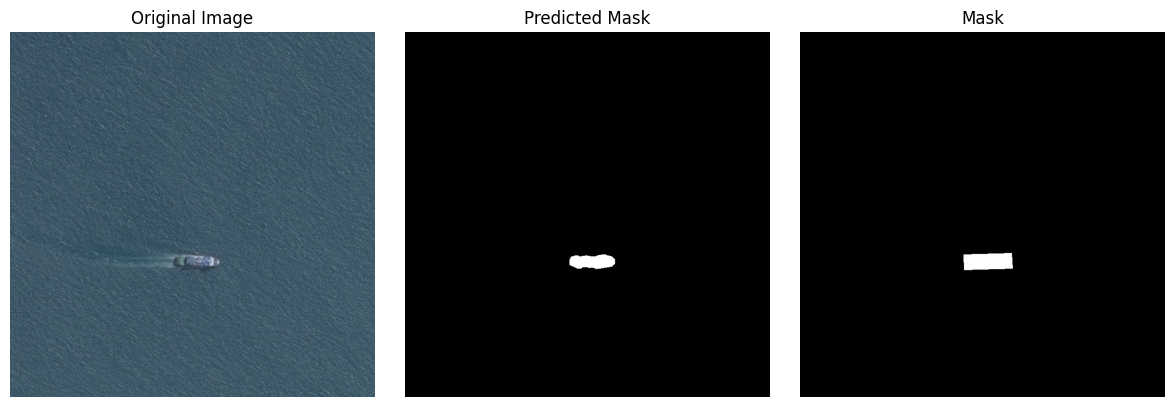

In [ ]:
# Normalization for image patches
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def segment_full_image(image_path, model, patch_size=256):
    
    """
    Segments a full image using a trained model by processing it in patches.
    This function divides the input image into non-overlapping patches of size `patch_size` x `patch_size`,
    applies the model to each patch, and combines the results into a full mask.

    Parameters
    ----------
    image_path : str
        Path to the input image file.
    model : torch.nn.Module
        The trained segmentation model to use for inference.
    patch_size : int, optional 
        Size of the square patches to extract from the image. Default is 256.

    Returns
    -------
    mask : np.ndarray
        A binary mask of the same size as the input image, where each pixel is classified as ship (1) or not ship (0).
    """

    image = np.array(Image.open(image_path).convert("RGB"))
    h, w, _ = image.shape

    # Prepare the output mask
    mask = np.zeros((h, w), dtype=np.float32)

    # Process the image in patches
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]

            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                continue  # Skip incomplete patches

            # Convert to tensor and normalize
            patch_tensor = torch.from_numpy(patch).permute(2, 0, 1).float() / 255.0
            patch_tensor = normalize(patch_tensor)

            with torch.no_grad():
                pred = model(patch_tensor.unsqueeze(0).to(device))  # (1, 1, H, W)
                prob_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
                bin_mask = (prob_mask > 0.5).astype(np.float32)

            mask[y:y+patch_size, x:x+patch_size] = bin_mask

    return mask


image_path = "./airbus-ship-detection/train_v2/000155de5.jpg"
mask_path = "./airbus-ship-detection/train_masks/000155de5.png"
predicted_mask = segment_full_image(image_path, model, patch_size=256)

# Visualize original image, predicted mask and mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(Image.open(image_path).convert("RGB"))
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(Image.open(mask_path).convert("RGB"))
plt.title("Mask")
plt.axis('off')
plt.tight_layout()

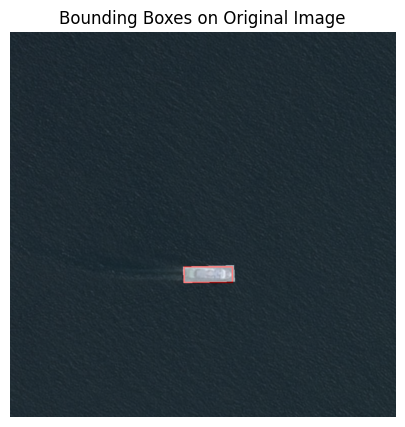

In [ ]:
def draw_bounding_boxes(mask, image_path, mask_path):
    """
    Draws bounding boxes around detected ships in the predicted mask and overlays them on the original image.
    
    Parameters
    ----------
    mask : np.ndarray
        The predicted binary mask where ships are marked.
    image_path : str
        Path to the original image file.
    mask_path : str
        Path to the ground truth mask file (for visualization purposes).
    """


    # Load the original image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    mask = np.array(Image.open(mask_path).convert("L"))

    # Find contours in the mask
    contours, _ = cv2.findContours(predicted_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes
    for contour in contours:
        if cv2.contourArea(contour) < 100:  # Filter out small areas
            continue
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_np, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display the result
    plt.figure(figsize=(10, 5))
    plt.imshow(image_np)
    plt.imshow(mask, alpha=0.5, cmap='gray')  # Overlay the mask
    plt.title("Bounding Boxes on Original Image")
    plt.axis('off')
    plt.show()


draw_bounding_boxes(predicted_mask, image_path, mask_path)

## Unet++ Model
To improve segmentation performance, I experimented with several state-of-the-art (SOTA) architectures:

- **DeepLabV3** with encoder freezing
- **U-Net++** with encoder freezing and from scratch training
- **ResNet-based encoders (e.g., ResNet34, ResNet50)**

In some configurations, I attempted to freeze the encoder (pretrained on ImageNet) and adapt the decoder layers to better suit the binary ship segmentation task.

However, these models had significant training times. Despite the architectural complexity, the final performance was inferior or comparable to lighter custom solutions, especially when trained under the same resource and time constraints.

The papers below offer more smart and better-performance approach, resulting in a different way to address the challenge.

**References:**
1. Mazen, Fatma & Mazen, Amna. (2025). *Airbus Ship Classification, Detection and Segmentation using Cutting-Edge Deep Learning Techniques*. Fayoum University Journal of Engineering, 8, 68–78. [https://doi.org/10.21608/fuje.2024.300746.1083](https://doi.org/10.21608/fuje.2024.300746.1083)

2. Al-Saad, Mina et al. (2021). *Airbus Ship Detection from Satellite Imagery Using Frequency Domain Learning*. Proceedings of SPIE, 35. [https://doi.org/10.1117/12.2600168](https://doi.org/10.1117/12.2600168)


In [ ]:
# U-Net++ (often better for small objects)
unet = smp.UnetPlusPlus(
    encoder_name='resnet34', 
    encoder_weights=None,  # Use pretraining
    classes=1
)

if TRAIN == False:
    print("Loading the pretrained Unet++ model...")
    # Load the pretrained weights
    unet.load_state_dict(torch.load("best_unet++.pth"), strict=False)

    print("Unet++ model loaded successfully.")

unet.to(device)

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Even lower than before


# Training loop
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    epoch_loss = 0.0
    dice_score = 0.0

    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
 
        outputs = model(images)
        loss = combined_loss(outputs, masks)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        optimizer.step()

        # Only metric computation – no gradients needed
        with torch.no_grad():
            preds = (torch.sigmoid(outputs) > 0.5).float()
            dice = dice_coefficient(preds, masks)  # Changed 'pred' to 'preds'

        epoch_loss += loss.item()
        dice_score += dice.item()

    return epoch_loss / len(dataloader), dice_score / len(dataloader)


# Validation loop
def validate_one_epoch(model, dataloader, device):
    model.eval()
    val_loss = 0.0
    dice_score = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = combined_loss(outputs, masks)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            dice = dice_coefficient(preds, masks)  # Changed 'pred' to 'preds')

            val_loss += loss.item()
            dice_score += dice.item()

    return val_loss / len(dataloader), dice_score / len(dataloader)

In [ ]:
import torch.nn.functional as F

if TRAIN == True:
    num_epochs = 20
    best_dice = 0

    train_unet_losses = []
    val_unet_losses = []
    train_unet_dices = []
    val_unet_dices = []


    for epoch in range(num_epochs):
        print(f"\n Epoch {epoch + 1}/{num_epochs}")

        train_loss, train_dice = train_one_epoch(unet, train_dataloader, optimizer, device)
        val_loss, val_dice = validate_one_epoch(unet, val_dataloader, device)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

        # Store metrics for plotting
        train_unet_losses.append(train_loss)
        val_unet_losses.append(val_loss)
        train_unet_dices.append(train_dice)
        val_unet_dices.append(val_dice)

        scheduler.step(val_loss)

        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(unet.state_dict(), "best_unet++.pth")
            print("Best model saved.")

    print("Training complete")
    unet_metrics_df = pd.DataFrame({
        'Epoch': range(1, len(train_unet_losses) + 1),
        'Train Loss': train_unet_losses,
        'Val Loss': val_unet_losses,
        'Train Dice': train_unet_dices,
        'Val Dice': val_unet_dices
    })
    unet_metrics_df.to_csv("unet++_training_metrics.csv", index=False)
    

In [ ]:
train_deep_losses = pd.read_csv("deep_training_metrics.csv")['Train Loss'].tolist()
val_deep_losses = pd.read_csv("deep_training_metrics.csv")['Val Loss'].tolist()
train_deep_dices = pd.read_csv("deep_training_metrics.csv")['Train Dice'].tolist()
val_deep_dices = pd.read_csv("deep_training_metrics.csv")['Val Dice'].tolist()

# plot training and validation loss and dice score
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_deep_losses) + 1), train_deep_losses, 'b-', label='Train Loss')
plt.plot(range(1, len(val_deep_losses) + 1), val_deep_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_deep_dices) + 1), train_deep_dices, 'b-', label='Train Dice')
plt.plot(range(1, len(val_deep_dices) + 1), val_deep_dices, 'r-', label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
image_path = "./airbus-ship-detection/train_v2/000155de5.jpg"
mask_path = "./airbus-ship-detection/train_masks/000155de5.png"

unet.eval()  # Set model to evaluation mode to avoid BatchNorm error
predicted_mask = segment_full_image(image_path, unet, patch_size=256)
# Visualize original image, predicted mask and mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(Image.open(image_path).convert("RGB"))
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(Image.open(mask_path).convert("RGB"))
plt.title("Mask")
plt.axis('off')
plt.tight_layout()
plt.show()